<a href="https://colab.research.google.com/github/fatemehalipour/DNADataAugmentation/blob/main/Data_Augmentation_with_DNABERT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive/")

%cd /content/drive/My Drive/DNA Dictionary

Mounted at /content/drive/
/content/drive/My Drive/DNA Dictionary


# Data Augmentation with DNABERT-2

## 1. Data Encoding with DNABERT-2


In [ ]:
import torch

# DNABERT requirements
!pip install -q transformers==4.29.2
!pip install -q einops
!pip uninstall -y -q triton

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


# install biopython, import it if available
try:
  import Bio
except:
  !pip install -q biopython
  import Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
[INFO] Couldn't find torchinfo... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.3 MB/s eta 0:00:00


Restart runtime after running the above cell.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.1 Reading the data

We read the sequences from a `.fasta` file.

In [ ]:
from pathlib import Path
from Bio import SeqIO

def rna_to_dna_sequence(rna_sequence):
    return rna_sequence.replace("U", "T")

def read_data_from_fasta(fasta_path:str,
                         rna_flag:bool=False,
                         remove_seq_with_ns:bool=True):
  """
  Takes in path to fasta file, read and preprocess the data return a dictionary
  of sequences in form of sequence_id: sequence
  Preprocess steps consists of convert to DNA if RNA_flag==true and removing the
  sequences tat contain any characters other than [A, C, G, T]
  """
  records = SeqIO.parse(fasta_path, "fasta")

  dna_sequences = {}
  for record in records:
    seq_id = record.name
    seq = str(record.seq)

    # convert RNA to DNA
    if rna_flag:
      seq = rna_to_dna_sequence(seq)

    # replace all invalid nucleotides with N
    for nuc in seq:
      if nuc not in ["A", "C", "G", "T"]:
        seq = seq.replace(nuc, "N")

    # remove sequences that contain at least one N
    if remove_seq_with_ns:
      if "N" not in seq:
        dna_sequences[seq_id] = seq
    else:
      dna_sequences[seq_id] = seq

  return dna_sequences


# Setup path to a data folder
data_path = Path("data/")
astrovirus_path = data_path / "astrovirus.fasta"


astrovirus_sequences = read_data_from_fasta(fasta_path=astrovirus_path,
                                            rna_flag=True,
                                            remove_seq_with_ns=True)

print(f"The resulting dataset size: {len(astrovirus_sequences)}")

The resulting dataset size: 634


In [ ]:
import pandas as pd
metadata_genus_df = pd.read_csv(data_path / "metadata_genus.csv")

def extract_genus_label(seq_name: str,
                        metadata_df=metadata_genus_df):
  """
  A function that extract the genus level label of a sequence record.
  """
  metadata_df = metadata_df.set_index(["Name"])
  return metadata_df.loc[seq_name, "Genus"]

In [ ]:
class_names = sorted(["Avastrovirus", "Mamastrovirus"])
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

### 1.2 Creating tokenizer and a pretrained DNABERT2 model

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True).to(device)

tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


bert_layers.py:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

bert_padding.py:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- bert_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


flash_attn_triton.py:   0%|          | 0.00/42.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- bert_layers.py
- bert_padding.py
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly

In [ ]:
model.device

device(type='cuda', index=0)

### 1.3 Inputing a sample sequence to the model

In [ ]:
import random

random.seed(42)

sequence = random.choice(list(astrovirus_sequences.values()))
print(f"The length of random sequence: {len(sequence)}bp")

# tokenization
tokenized_sequence = tokenizer(sequence, return_tensors = "pt")["input_ids"]
print(f"The shape of tokenized random sequence: {tokenized_sequence.shape}")
tokenized_sequence = tokenized_sequence.to(device)

# feeding the tokenized sequence into DNABERT2 model
hidden_states = model(tokenized_sequence)[0] # [1, sequence_length, 768]
print(f"The shape of random sequence in embedded space: {hidden_states.shape}")
# print(hidden_states)

# embedding with mean pooling
embedding_mean = torch.mean(hidden_states[0], dim=0)
print(f"The shape of embedding with mean pooling: {embedding_mean.shape}") # expect to be 768

# embedding with max pooling
embedding_max = torch.max(hidden_states[0], dim=0)[0]
print(embedding_max.shape) # expect to be 768

The length of random sequence: 6759bp
The shape of tokenized random sequence: torch.Size([1, 1420])


/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: Increasing alibi size from 512 to 1420
  warnings.warn(


The shape of random sequence in embedded space: torch.Size([1, 1420, 768])
The shape of embedding with mean pooling: torch.Size([768])
torch.Size([768])


### 1.4 Getting embeddings of all the sequences

In [ ]:
import random
from tqdm.auto import tqdm

y = []
X = []
for accession_id, sequence in tqdm(astrovirus_sequences.items()):
  torch.cuda.empty_cache()
  # if i == 35:
  #   break
  y.append(extract_genus_label(accession_id))

  # tokenization
  tokenized_sequence = tokenizer(sequence, return_tensors = "pt")["input_ids"]
  tokenized_sequence = tokenized_sequence.to(device)

  # feeding the tokenized sequence into DNABERT2 model
  model.eval()
  with torch.inference_mode():
    hidden_states = model(tokenized_sequence)[0] # [1, sequence_length, 768]

  # embedding with mean pooling
  embedding_mean = torch.mean(hidden_states[0], dim=0)
  X.append(embedding_mean)

X = torch.stack(X)
# y = torch.stack(y)

print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")

  0%|          | 0/634 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: Increasing alibi size from 1420 to 1421
  warnings.warn(
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: Increasing alibi size from 1421 to 1479
  warnings.warn(
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: Increasing alibi size from 1479 to 1483
  warnings.warn(
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: Increasing alibi size from 1483 to 1489
  warnings.warn(
/root/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/1d020b803b871a976f5f3d5565f0eac8f2c7bb81/bert_layers.py:432: UserWarning: In

X shape: torch.Size([634, 768])
y shape: 634


h_embedded shape: (634, 2)


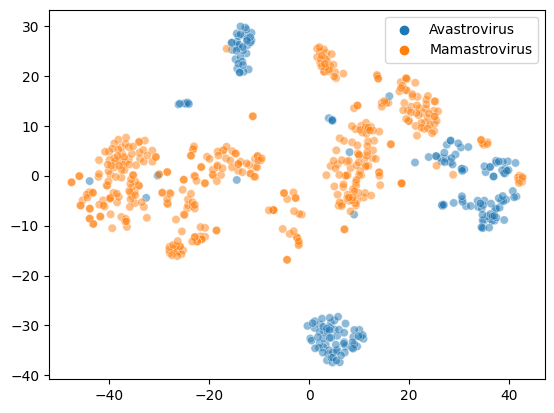

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
X = X.cpu().detach()

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2,
                  learning_rate="auto",
                  init="pca").fit_transform(X.numpy())
print(f"h_embedded shape: {h_embedded.shape}")

# Plot
ax = sns.scatterplot(x=h_embedded[:,0],
                     y=h_embedded[:,1],
                     hue=y,
                     alpha=0.5,
                     palette="tab10")



### 1.5. Visualizing embedded space

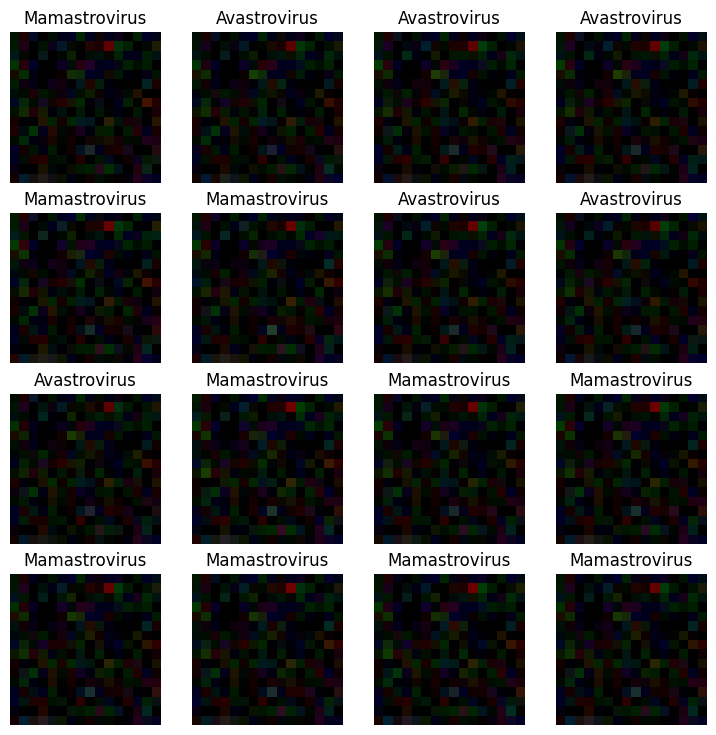

In [ ]:
X_reshaped = X.reshape(634, 3, 16, 16)

# Plot images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9));
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(y), size=[1]).item()
  img = X_reshaped[random_idx, :, :, :]
  label = y[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(label)
  plt.axis(False)

### 1.6. Creating Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset
from typing import Tuple

class SeqData(Dataset):
  def __init__(self, sequences, labels, class_names, class_to_idx, transform=None):
    self.sequences = sequences
    self.labels = labels
    self.transform = transform
    self.classes = class_names
    self.class_to_idx = class_to_idx


  def __len__(self) -> int:
    """
    Return total number of sequecnes
    """
    return self.sequences.shape[0]

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data, seq and label (X, y)
    """
    seq = self.sequences[index]
    label = self.class_to_idx[self.labels[index]]

    # Transform if necessary
    if self.transform:
      return self.transform(seq), label
    else:
      return seq, label

In [ ]:
train_data = SeqData(sequences=X_reshaped,
                     labels=y,
                     class_names=class_names,
                     class_to_idx=class_to_idx)
print(f"Length of training data: {len(train_data)}")

Length of training data: 634


In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

train_dataloader, len(train_dataloader),

(<torch.utils.data.dataloader.DataLoader at 0x7c83319b3fd0>, 10)

## 2. Generating Data Augmentation

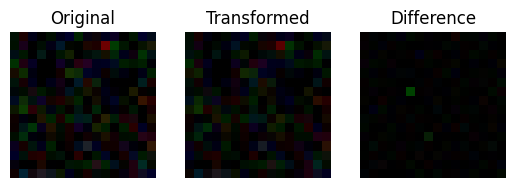

In [ ]:
from torchvision.transforms import v2

img = X_reshaped[10, :, :, :]

transforms_normalization = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    v2.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.5))
])

fig, ax = plt.subplots(nrows=1, ncols=3)
transformed_image_1 = transforms_normalization(img)
ax[0].imshow(transformed_image_1.permute(1, 2, 0))
ax[0].set_title(f"Original")
ax[0].axis(False)

# Transform and plot target image
transformed_image_2 = transforms(img) # not we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
ax[1].imshow(transformed_image_2.permute(1, 2, 0))
ax[1].set_title(f"Transformed")
ax[1].axis(False)

# Transform and plot target image
difference = transformed_image_2 - transformed_image_1 # not we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
ax[2].imshow(difference.permute(1, 2, 0))
ax[2].set_title(f"Difference")
ax[2].axis(False);

# fig.suptitle(f"Class: {y[0]}", fontsize=16);

## 3. Model

In [ ]:
from torch import nn
from torchvision.ops import MLP

class EmbeddedClusteringModel(torch.nn.Module):
  def __init__(self,
               input_shape:int=3,
               hidden_units:int=10,
               mlp_size:int=64,
               mlp_dropout:float=0.1,
               output_shape:int=len(class_names)):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1) # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1) # default stride value is same as kernel size
    )

    self.mlp = nn.Sequential(
        nn.Linear(in_features=6,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=1),
        nn.Dropout(p=mlp_dropout),
    )

  def forward(self, x, train=True):
    if train:
      # Get 2 augmentations of the batch
      x_aug_1 = transforms(x)
      x_aug_2 = transforms(x)

      # Get representations for first augmented view
      h_1 = self.conv_block_1(x_aug_1)
      h_1 = self.conv_block_2(h_1)

      # Get representations for second augmented view
      h_2 = self.conv_block_1(x_aug_2)
      h_2 = self.conv_block_2(h_2)

    else:
      x = transforms_normalization(x)
      h = self.conv_block(x)
      h = self.encoder(h)
      return h

    # Transformation for loss function
    compact_h_1 = self.mlp(h_1)
    compact_h_2 = self.mlp(h_2)
    return h_1, h_2, compact_h_1, compact_h_2

In [ ]:
# dummy pass on first batch
first_batch = next(iter(train_dataloader))[0].to(device)

model = EmbeddedClusteringModel().to(device)
model(first_batch);

RuntimeError: ignored

In [ ]:
# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(EmbeddedClusteringModel(),
        input_size=first_batch.shape, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
EmbeddedClusteringModel (EmbeddedClusteringModel)  [64, 3, 16, 16]      [64, 10, 6, 6]       --                   True
├─Sequential (conv_block_1)                        [64, 3, 16, 16]      [64, 10, 11, 11]     --                   True
│    └─Conv2d (0)                                  [64, 3, 16, 16]      [64, 10, 14, 14]     280                  True
│    └─ReLU (1)                                    [64, 10, 14, 14]     [64, 10, 14, 14]     --                   --
│    └─Conv2d (2)                                  [64, 10, 14, 14]     [64, 10, 12, 12]     910                  True
│    └─ReLU (3)                                    [64, 10, 12, 12]     [64, 10, 12, 12]     --                   --
│    └─MaxPool2d (4)                               [64, 10, 12, 12]     [64, 10, 11, 11]     --                   --
├─Sequential (conv_block_2)                      

## 4. Training

In [ ]:
# See https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss
!pip install pytorch-metric-learning -q

from pytorch_metric_learning.losses import NTXentLoss
loss_fn = NTXentLoss(temperature=0.10)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
next

In [ ]:
import tqdm

def train():
  model.train()
  total_loss = 0
  for _, (data, _) in enumerate(tqdm.tqdm(train_dataloader)):
    data = data.to(device)

    # Forward pass to get data representations
    h_1, h_2, compact_h_1, compact_h_2 = model(data)

    # Calculate the loss
    # Prepare for loss
    embeddings = torch.cat((compact_h_1, compact_h_2))
    # The same index corresponds to a positive pair
    indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
    labels = torch.cat((indices, indices))
    loss = loss_fn(embeddings, labels)

    # Optimizer zero grad
    optimizer.zero_grad()

    # perform backpropagation on the loss with repect to the parameters of the model
    loss.backward()
    total_loss += loss.item()

    optimizer.step()
  return total_loss / len(train_data)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: ignored